Baesed on `pretrain_02.ipynb` works, I implement learning rate scheduler to the training. It starts from 10 epochs for warmup, then stay constant for 20 epochs, and finally decay to 0.0 during the last 30 epochs. The model is trained from scratch rather than using the pretrained weights from the pilot study. Details can be found in `main_pretrain_schlr.py`. `num_workers` in `datasets.py` is increased to 10, which is same as MAE, to speed up the increased training time due to scheduler. 

The references talking about warmup and cosine decay are [Gotmare et al., 2018](https://arxiv.org/abs/1810.13243) and [Loshchilov & Hutter, 2016](https://arxiv.org/abs/1608.03983).
```
ViT model: base
Learning rate: testing
Optimizer: AdamW (betas=(0.9, 0.95)) 
Clips gradient norm
Data pre-processing: spectrum-wise standardization
Patch size: 16
Mask ratio: 0.75
Batch size: 256
Epochs: 60
```

A warning pops up when the training is changing from the first scheduler to the second scheduler. 

```
/home/vscode/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
```

After digging out the forums, I think it's a bug of PyTorch. The warning can be ignored. It's because I didn't put any parameter in `scheduler.step()` described by the warning. The parameter is put by the `SequentialLR` class automatically. Some posts just ignore it.

In [1]:
import pandas as pd

lr_df = pd.read_csv('results/tuning_l-coslr_20231228.csv')
lr_df

,lr,min_val_loss
0,0.001000,0.869926
1,0.000100,0.146009
2,0.000010,0.008753
3,0.000001,0.046426


Text(0, 0.5, 'Last validation loss in 60 epochs')

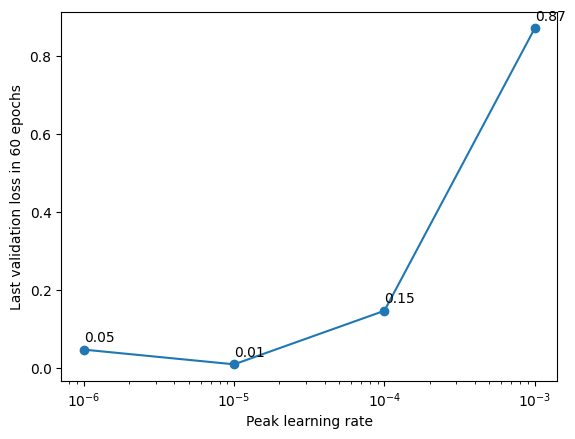

In [2]:
import matplotlib.pyplot as plt
plt.plot(lr_df.lr, lr_df.min_val_loss, 'o-')
plt.xscale('log')
for lr, loss in zip(lr_df.lr, lr_df.min_val_loss):
    plt.text(lr, loss+.02, round(loss, 2))
plt.xlabel('Peak learning rate')
plt.ylabel('Last validation loss in 60 epochs')

________________________________________________________________________________
Learning rate: 0.001


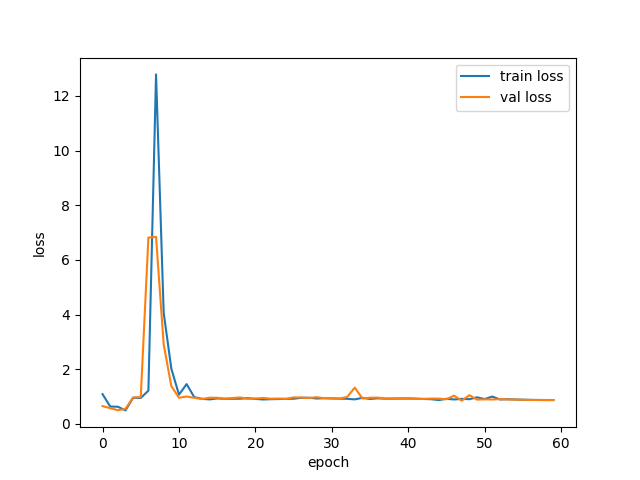

________________________________________________________________________________
Learning rate: 0.0001


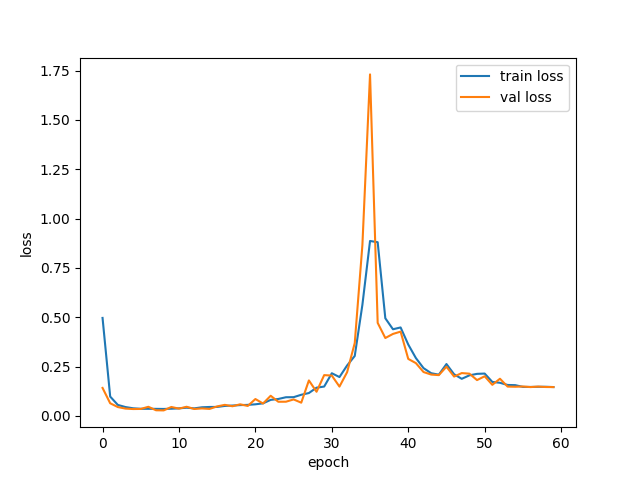

________________________________________________________________________________
Learning rate: 1e-05


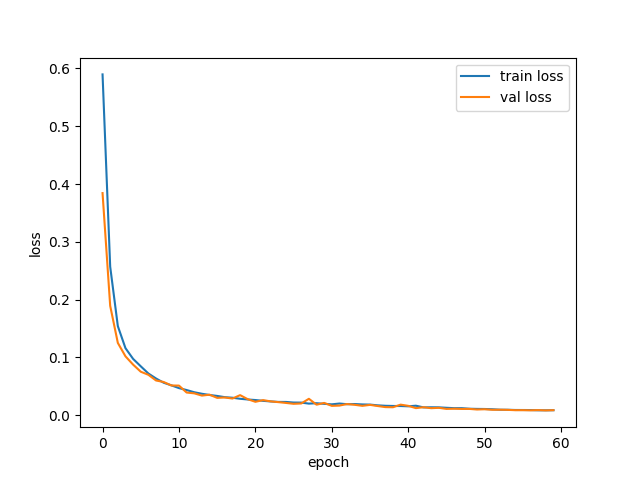

________________________________________________________________________________
Learning rate: 1e-06


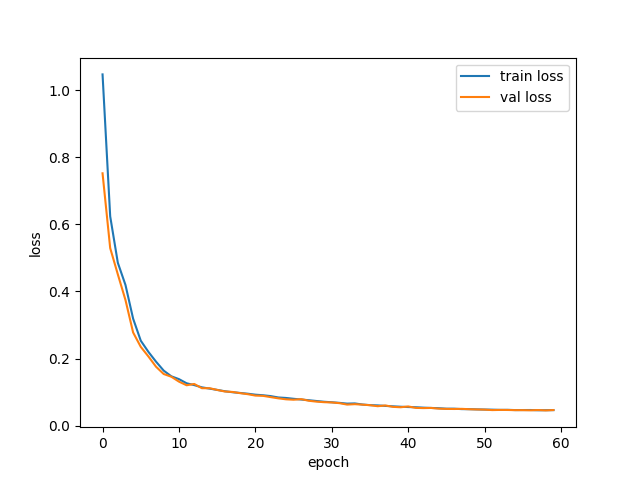

In [3]:
from IPython.display import Image, display
for lr in lr_df['lr']:
    img = Image(filename=f'results/loss_l-coslr_{lr}_20231228.png')
    print('_'*80)
    print(f'Learning rate: {lr}')
    display(img)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def get_logs(filename):
    epoch_list = []
    train_loss_list = []
    val_loss_list = []
    lr_list = []

    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.split()
            epoch_list.append(int(line[2]))
            train_loss_list.append(float(line[9]))
            val_loss_list.append(float(line[13]))
            lr_list.append(float(line[-1]))
        df = pd.DataFrame({'epoch': epoch_list,
                           'train_loss': train_loss_list,
                           'val_loss': val_loss_list, 
                           'lr': lr_list})
    return df

def visualize(train_loss_list, val_loss_list, ylim: tuple=None):
    plt.figure()
    plt.plot(train_loss_list, label='train loss')
    plt.plot(val_loss_list, label='val loss')
    if ylim:
        plt.ylim(*ylim)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


Schedule lr: 1e-05


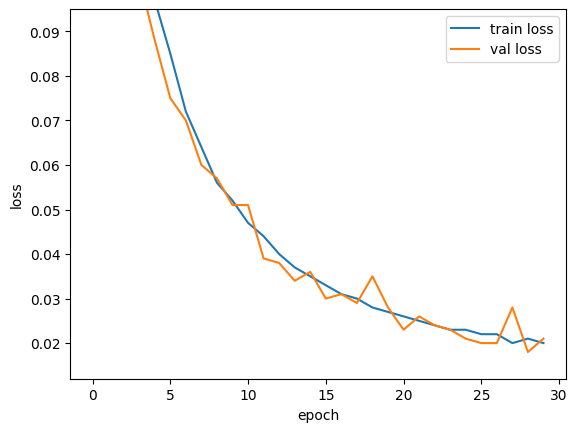

Constant lr: 1e-05


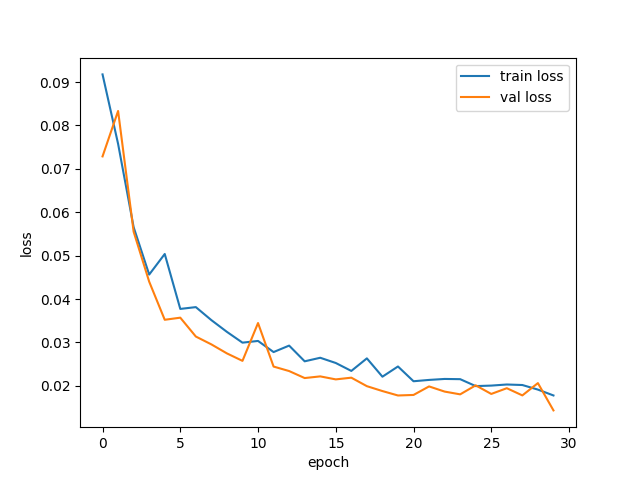

In [5]:
lr = 1e-05
print(f'Schedule lr: {lr}')
df5 = get_logs(f'results/logs_l-coslr_{lr}_20231228.txt')
visualize(df5.train_loss[:30], df5.val_loss[:30], ylim=(0.012, 0.095))

print(f'Constant lr: {lr}')
img = Image(filename=f'results/loss_{lr}_20231225.png')
display(img)

Schedule lr: 1e-06


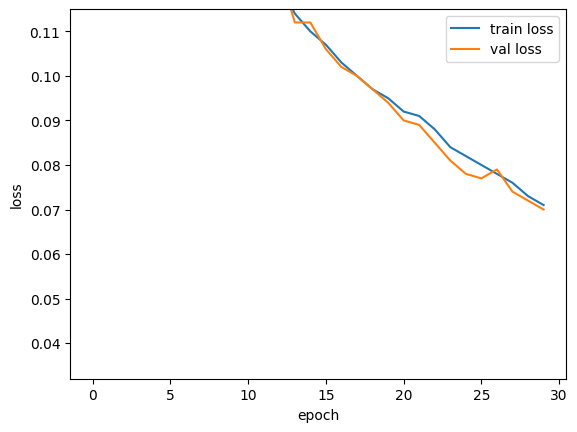

Constant lr: 1e-06


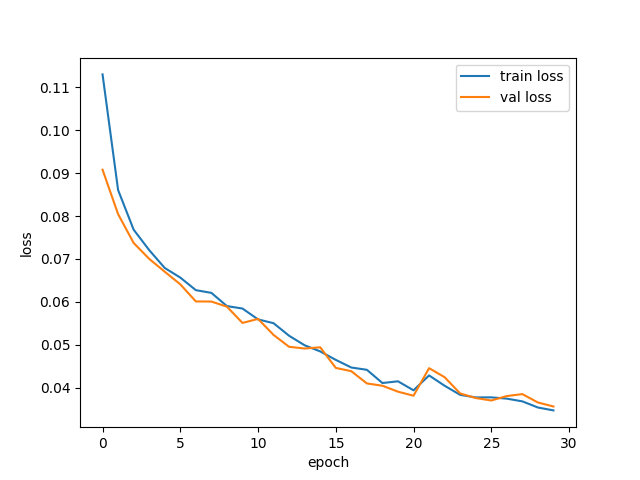

In [6]:
lr = 1e-06
print(f'Schedule lr: {lr}')
df6 = get_logs(f'results/logs_l-coslr_{lr}_20231228.txt')
visualize(df6.train_loss[:30], df6.val_loss[:30], ylim=(0.032, 0.115))

print(f'Constant lr: {lr}')
img = Image(filename=f'results/loss_{lr}_20231225.png')
display(img)

Let's disregard the diverging models with learning rates: 1e-3 and 1e-4, and focus on those converging (1e-5 and 1e-6). If we compare them with the constant lr in the same amount of training epoch, the scheduled lr actually doesn't help much. But it's rather not a fair comparison because the constant lr is trained based on the pretrained weights while the scheduled lr is trained from scratch.

## Constant or scheduled lr?
This time I train the models all from the scratch and have the same amount of training epochs. But I only focus on lr 1e-5 and 1e-6. The results are shown below. 

In [7]:
logs_dict = {
    'Constant': {
        '1e-5': get_logs(f'results/logs_lr_1e-05_20231229.txt'),
        '1e-6': get_logs(f'results/logs_lr_1e-06_20231229.txt')
    },
    'Schedule': {
        '1e-5': get_logs(f'results/logs_l-coslr_1e-05_20231229.txt'),
        '1e-6': get_logs(f'results/logs_l-coslr_1e-06_20231229.txt')
    }
}

Constant 1e-5
Val loss:  0.0100


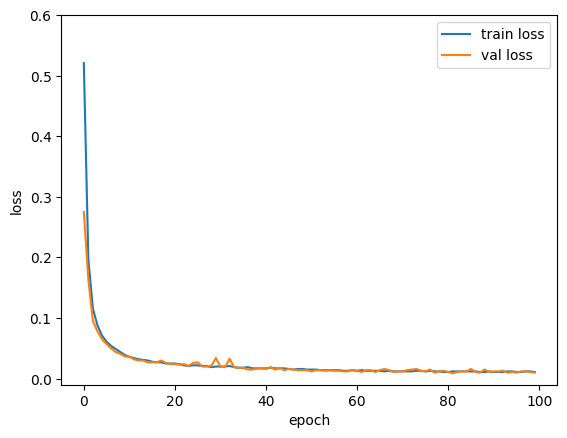

Schedule 1e-5
Val loss:  0.0060


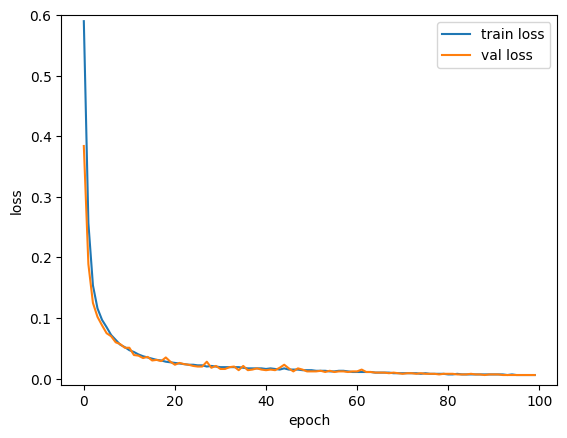

In [8]:
lr='1e-5'
for key, value in logs_dict.items():
    print(f'{key} {lr}\nVal loss: {logs_dict[key][lr].val_loss[99]: 1.4f}')
    visualize(logs_dict[key][lr].train_loss, logs_dict[key][lr].val_loss, ylim=(-0.01, 0.6))


Constant 1e-6
Val loss:  0.0270


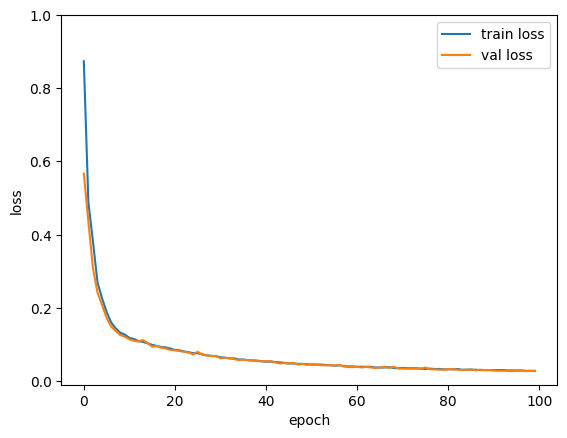

Schedule 1e-6
Val loss:  0.0340


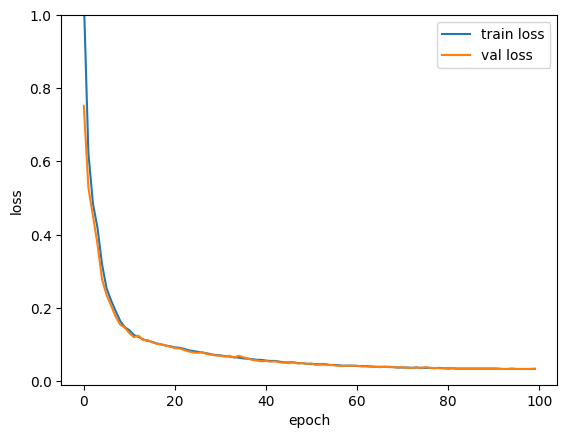

In [9]:
lr='1e-6'
for key, value in logs_dict.items():
    print(f'{key} {lr}\nVal loss: {logs_dict[key][lr].val_loss[99]: 1.4f}')
    visualize(logs_dict[key][lr].train_loss, logs_dict[key][lr].val_loss, ylim=(-0.01, 1))

In [10]:
df = pd.concat([
    pd.read_csv('results/tuning_lr_20231229.csv'),
    pd.read_csv('results/tuning_l-coslr_20231229.csv')
])
df

,lr,min_val_loss
0,0.000010,0.009995
1,0.000001,0.026816
0,0.000010,0.006450
1,0.000001,0.033587


Overall, the models trained by 1e-5 as the peak lr has better performance than those trained by 1e-6. Yet, the schedule lr doesn't always help.

I'll take the model trained by scheduled 1e-5 as the optimal model so far.